# [SF-DST] Credit Scoring. Прогнозирование вероятности дефолта заемщика

## Import

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)
from pandas import Series

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc, roc_auc_score, roc_curve

random_state = 42

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('./kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

./kaggle/input/.DS_Store
./kaggle/input/sf-dst-scoring/.DS_Store
./kaggle/input/sf-dst-scoring/test.csv
./kaggle/input/sf-dst-scoring/train.csv
./kaggle/input/sf-dst-scoring/sample_submission.csv


## Data

In [2]:
# DATA_DIR = '/kaggle/input/sf-dst-scoring/'
DATA_DIR = './kaggle/input/sf-dst-scoring/'
df_train = pd.read_csv(DATA_DIR + '/train.csv')
df_test = pd.read_csv(DATA_DIR + 'test.csv')
sample_submission = pd.read_csv(DATA_DIR + '/sample_submission.csv')

In [3]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73799 entries, 0 to 73798
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         73799 non-null  int64  
 1   app_date          73799 non-null  object 
 2   education         73492 non-null  object 
 3   sex               73799 non-null  object 
 4   age               73799 non-null  int64  
 5   car               73799 non-null  object 
 6   car_type          73799 non-null  object 
 7   decline_app_cnt   73799 non-null  int64  
 8   good_work         73799 non-null  int64  
 9   score_bki         73799 non-null  float64
 10  bki_request_cnt   73799 non-null  int64  
 11  region_rating     73799 non-null  int64  
 12  home_address      73799 non-null  int64  
 13  work_address      73799 non-null  int64  
 14  income            73799 non-null  int64  
 15  sna               73799 non-null  int64  
 16  first_time        73799 non-null  int64 

In [4]:
df_train.head(5)

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default
0,25905,01FEB2014,SCH,M,62,Y,Y,0,0,-2.008753,1,50,1,2,18000,4,1,N,0
1,63161,12MAR2014,SCH,F,59,N,N,0,0,-1.532276,3,50,2,3,19000,4,1,N,0
2,25887,01FEB2014,SCH,M,25,Y,N,2,0,-1.408142,1,80,1,2,30000,1,4,Y,0
3,16222,23JAN2014,SCH,F,53,N,N,0,0,-2.057471,2,50,2,3,10000,1,3,N,0
4,101655,18APR2014,GRD,M,48,N,N,0,1,-1.244723,1,60,2,3,30000,1,4,Y,0


In [5]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36349 entries, 0 to 36348
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         36349 non-null  int64  
 1   app_date          36349 non-null  object 
 2   education         36178 non-null  object 
 3   sex               36349 non-null  object 
 4   age               36349 non-null  int64  
 5   car               36349 non-null  object 
 6   car_type          36349 non-null  object 
 7   decline_app_cnt   36349 non-null  int64  
 8   good_work         36349 non-null  int64  
 9   score_bki         36349 non-null  float64
 10  bki_request_cnt   36349 non-null  int64  
 11  region_rating     36349 non-null  int64  
 12  home_address      36349 non-null  int64  
 13  work_address      36349 non-null  int64  
 14  income            36349 non-null  int64  
 15  sna               36349 non-null  int64  
 16  first_time        36349 non-null  int64 

In [6]:
df_test.head(5)

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport
0,74835,22MAR2014,GRD,M,29,Y,Y,0,0,-2.271884,3,50,1,2,50000,1,4,N
1,17527,24JAN2014,SCH,F,39,N,N,5,0,-1.504999,2,50,1,2,5000,4,3,N
2,75683,23MAR2014,UGR,M,50,Y,Y,0,0,-1.691339,1,50,1,2,30000,1,3,Y
3,26883,03FEB2014,SCH,M,56,N,N,0,0,-2.374182,1,40,1,2,17000,1,3,N
4,28862,04FEB2014,GRD,F,38,N,N,0,0,-2.487502,0,80,2,3,120000,1,3,N


In [7]:
sample_submission.head(5)

,client_id,default
0,66799,0.441004
1,25379,0.138092
2,28825,0.373370
3,37530,0.476501
4,4264,0.304640


In [8]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24354 entries, 0 to 24353
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   client_id  24354 non-null  int64  
 1   default    24354 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 380.7 KB


In [9]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1  # помечаем где у нас трейн
df_test['sample'] = 0  # помечаем где у нас тест
df_test['default'] = 0  #

df = df_test.append(df_train, sort=False).reset_index(drop=True)  # объединяем

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   client_id         110148 non-null  int64  
 1   app_date          110148 non-null  object 
 2   education         109670 non-null  object 
 3   sex               110148 non-null  object 
 4   age               110148 non-null  int64  
 5   car               110148 non-null  object 
 6   car_type          110148 non-null  object 
 7   decline_app_cnt   110148 non-null  int64  
 8   good_work         110148 non-null  int64  
 9   score_bki         110148 non-null  float64
 10  bki_request_cnt   110148 non-null  int64  
 11  region_rating     110148 non-null  int64  
 12  home_address      110148 non-null  int64  
 13  work_address      110148 non-null  int64  
 14  income            110148 non-null  int64  
 15  sna               110148 non-null  int64  
 16  first_time        11

Описания полей
* client_id - идентификатор клиента
* education - уровень образования
* sex - пол заемщика
* age - возраст заемщика
* car - флаг наличия автомобиля
* car_type - флаг автомобиля иномарки
* decline_app_cnt - количество отказанных прошлых заявок
* good_work - флаг наличия “хорошей” работы
* bki_request_cnt - количество запросов в БКИ
* home_address - категоризатор домашнего адреса
* work_address - категоризатор рабочего адреса
* income - доход заемщика
* foreign_passport - наличие загранпаспорта
* sna - связь заемщика с клиентами банка
* first_time - давность наличия информации о заемщике
* score_bki - скоринговый балл по данным из БКИ
* region_rating - рейтинг региона
* app_date - дата подачи заявки
* default - флаг дефолта по кредиту

In [11]:
df.sample(5)

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,sample,default
43951,106717,25APR2014,UGR,F,21,N,N,0,1,-1.939739,1,80,2,3,40000,1,3,Y,1,0
1638,95531,11APR2014,SCH,F,58,N,N,0,0,-2.009471,2,50,1,2,12000,4,1,N,0,0
101564,21396,28JAN2014,UGR,F,65,N,N,0,1,-1.609077,3,60,1,1,28000,1,3,N,1,0
100845,68046,17MAR2014,SCH,F,66,N,N,0,0,-1.721330,1,60,2,3,7000,4,3,N,1,1
92456,35250,11FEB2014,SCH,F,39,Y,Y,0,0,-1.969645,0,80,2,3,30000,1,4,Y,1,0


## Целевая переменная

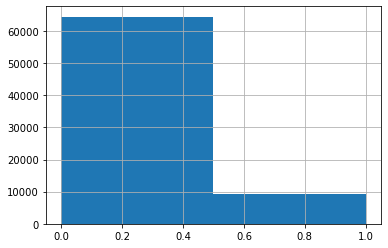

In [12]:
df['default'][df['sample'] == 1].hist(bins=2)

In [13]:
df[df['sample'] == 1]['default'].value_counts() / len(df)
df[df['sample'] == 1]['default'].value_counts()[0] / df[
    df['sample'] == 1]['default'].value_counts()[1]

0    0.584913
1    0.085086
Name: default, dtype: float64

6.874413145539906

Отношение класов целевой переменной около 7. 

## Заполнение пропусков

In [14]:
df.isna().sum()

client_id             0
app_date              0
education           478
sex                   0
age                   0
car                   0
car_type              0
decline_app_cnt       0
good_work             0
score_bki             0
bki_request_cnt       0
region_rating         0
home_address          0
work_address          0
income                0
sna                   0
first_time            0
foreign_passport      0
sample                0
default               0
dtype: int64

В данных о клиентах присутствуют переменные всех типов, не все имеют числовую запись, а также есть пропущенные значения.
Пропуски встречаются только в информации об образовании клиентов.

SCH    57998
GRD    34768
UGR    14748
PGR     1865
ACD      291
Name: education, dtype: int64

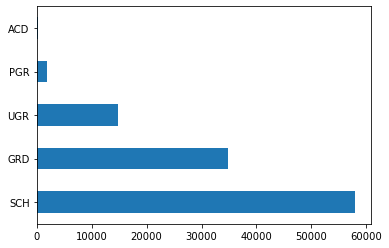

In [15]:
df['education'].value_counts().plot.barh()
df['education'].value_counts()

Заполним их самым частым значением.

In [16]:
df['education'].fillna('SCH', inplace=True)

## Разделение переменных по классам

Преобразуем app_date к формату datetime

In [17]:
df['app_date'] = pd.to_datetime(df['app_date'], format='%d%b%Y')

Создадим на основе его новый числовой параметр

In [18]:
df['days'] = (df['app_date'] - df['app_date'].min()).dt.days

In [19]:
bin_cols = ['sex', 'car', 'car_type', 'foreign_passport', 'good_work']
cat_cols = [
    'education', 'home_address', 'work_address', 'sna', 'first_time',
    'region_rating'
]
num_cols = [
    'age', 'decline_app_cnt', 'income', 'bki_request_cnt', 'score_bki', 'days'
]
date_cols = ['app_date']

## Числовых данные
### 'age', 'decline_app_cnt', 'income', 'bki_request_cnt', 'days'

In [20]:
num_cols1 = ['age', 'decline_app_cnt', 'income', 'bki_request_cnt', 'days']

<Figure size 432x288 with 0 Axes>

Text(0.5, 1.0, 'age')

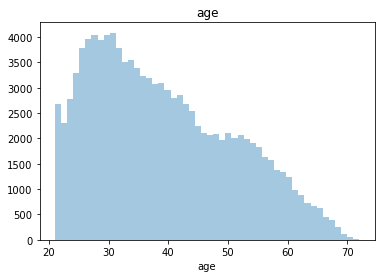

<Figure size 432x288 with 0 Axes>

Text(0.5, 1.0, 'decline_app_cnt')

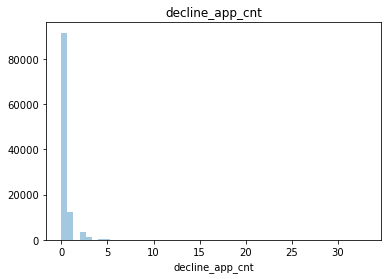

<Figure size 432x288 with 0 Axes>

Text(0.5, 1.0, 'income')

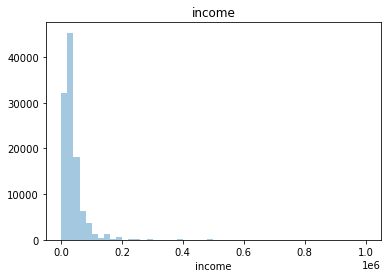

<Figure size 432x288 with 0 Axes>

Text(0.5, 1.0, 'bki_request_cnt')

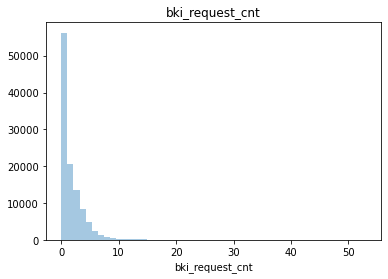

<Figure size 432x288 with 0 Axes>

Text(0.5, 1.0, 'days')

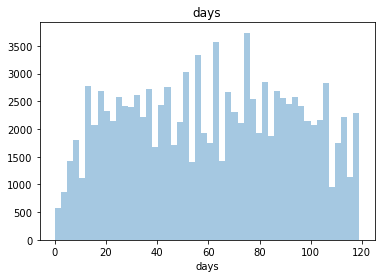

In [21]:
for i in num_cols1:
    plt.figure()
    sns.distplot(df[i], kde=False, rug=False)
    plt.title(i)
    plt.show()

<Figure size 432x288 with 0 Axes>

Text(0.5, 1.0, 'age')

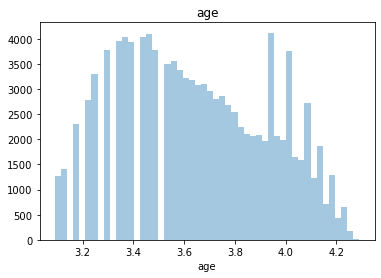

<Figure size 432x288 with 0 Axes>

Text(0.5, 1.0, 'decline_app_cnt')

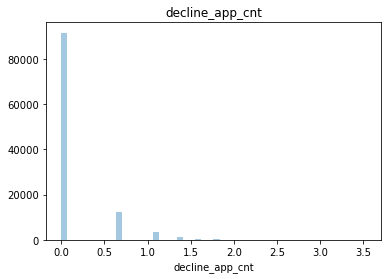

<Figure size 432x288 with 0 Axes>

Text(0.5, 1.0, 'income')

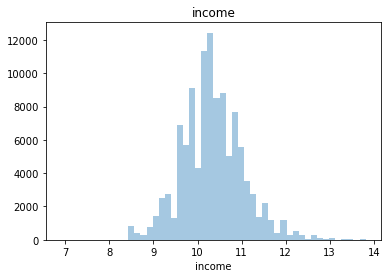

<Figure size 432x288 with 0 Axes>

Text(0.5, 1.0, 'bki_request_cnt')

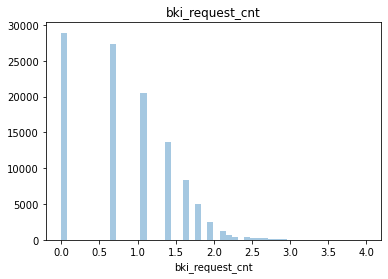

<Figure size 432x288 with 0 Axes>

Text(0.5, 1.0, 'days')

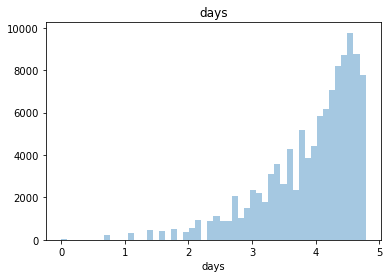

In [22]:
for i in num_cols1:
    plt.figure()
    sns.distplot(np.log(df[i] + 1), kde=False, rug=False)
    plt.title(i)
    plt.show()

Логарифмируем переменные 'age', 'decline_app_cnt', 'income', 'bki_request_cnt', 'days'

In [23]:
for i in num_cols1:
    df[i] = np.log(df[i] + 1)

### 'score_bki'

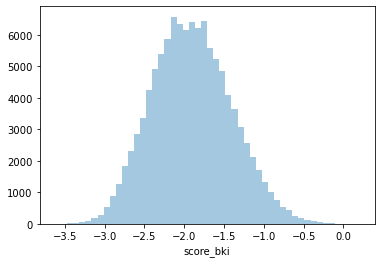

In [24]:
sns.distplot(df['score_bki'], kde=False, rug=False)

Оставим без изменения.

<Figure size 432x288 with 0 Axes>

Text(0.5, 1.0, 'age')

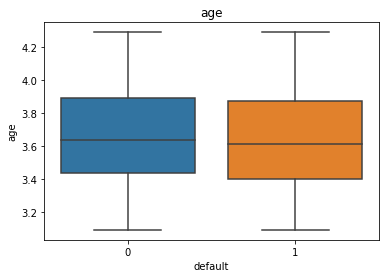

<Figure size 432x288 with 0 Axes>

Text(0.5, 1.0, 'decline_app_cnt')

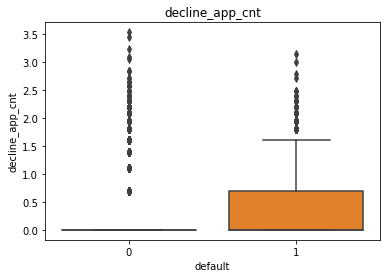

<Figure size 432x288 with 0 Axes>

Text(0.5, 1.0, 'income')

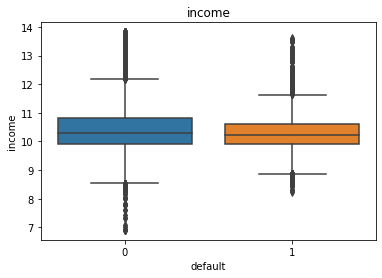

<Figure size 432x288 with 0 Axes>

Text(0.5, 1.0, 'bki_request_cnt')

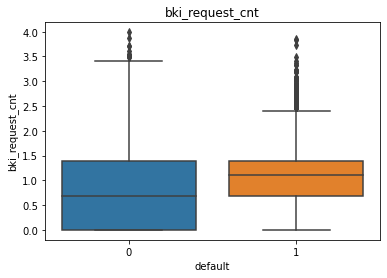

<Figure size 432x288 with 0 Axes>

Text(0.5, 1.0, 'score_bki')

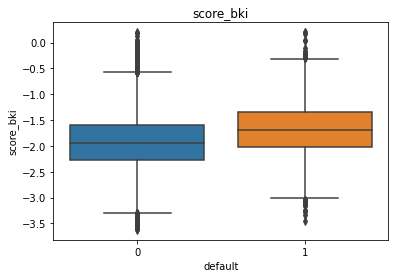

<Figure size 432x288 with 0 Axes>

Text(0.5, 1.0, 'days')

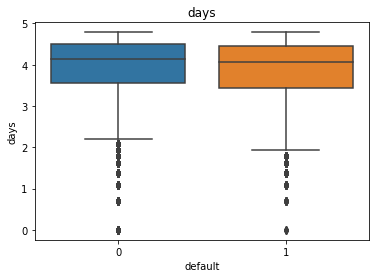

In [25]:
for i in num_cols:
    plt.figure()
    sns.boxplot(x='default', y=i, data=df)
    plt.title(i)
    plt.show()

### Поиск выбросов

In [26]:
df[num_cols].describe()

,age,decline_app_cnt,income,bki_request_cnt,score_bki,days
count,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000
mean,3.654546,0.151330,10.345792,0.878752,-1.904535,3.924964
std,0.285054,0.361331,0.696636,0.658667,0.499397,0.733249
min,3.091042,0.000000,6.908755,0.000000,-3.624586,0.000000
25%,3.433987,0.000000,9.903538,0.000000,-2.260434,3.526361
50%,3.637586,0.000000,10.308986,0.693147,-1.920823,4.143135
75%,3.891820,0.000000,10.778977,1.386294,-1.567888,4.499810
max,4.290459,3.526361,13.815512,3.988984,0.199773,4.787492


In [27]:
df1 = df[num_cols][df['sample'] == 1]
q_min = df.quantile(q=0.25) - 1.5 * (df.quantile(q=0.75) - df.quantile(q=0.25))
q_max = df.quantile(q=0.75) + 1.5 * (df.quantile(q=0.75) - df.quantile(q=0.25))

In [28]:
qfil = (df1 < q_min) | (df1 > q_max)
qfil.sum()
qfil.sum() / len(qfil)

age                    0
bki_request_cnt        9
client_id              0
days                1535
decline_app_cnt    12585
default                0
first_time             0
good_work              0
home_address           0
income              1767
region_rating          0
sample                 0
score_bki            340
sna                    0
work_address           0
dtype: int64

age                0.000000
bki_request_cnt    0.000122
client_id          0.000000
days               0.020800
decline_app_cnt    0.170531
default            0.000000
first_time         0.000000
good_work          0.000000
home_address       0.000000
income             0.023943
region_rating      0.000000
sample             0.000000
score_bki          0.004607
sna                0.000000
work_address       0.000000
dtype: float64

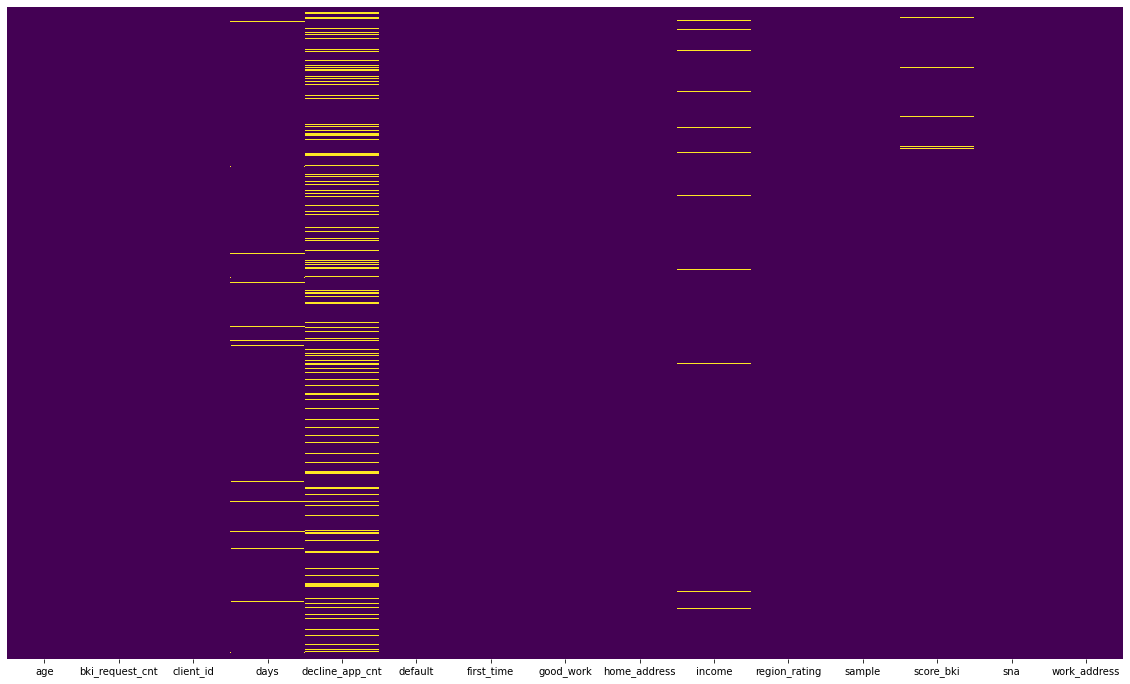

In [29]:
fig, ax = plt.subplots(figsize=(20, 12))
sns_heatmap = sns.heatmap(qfil, yticklabels=False, cbar=False, cmap='viridis')

Пока оставим все значения. Кандидаты на удаление выбросов: income, score_bki. 

### Корреляционный анализ 

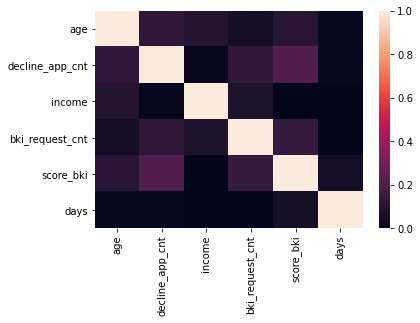

In [30]:
sns.heatmap(df[num_cols].corr().abs(), vmin=0, vmax=1)

Переменные имеют низкую корреляцию.

### Значимость непрерывных переменных

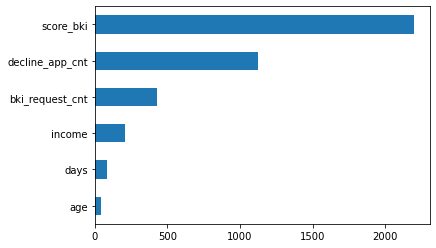

In [31]:
imp_num = Series(f_classif(df[num_cols], df['default'])[0], index=num_cols)
imp_num.sort_values(inplace=True)
imp_num.plot(kind='barh')

Наиболее значимый параметр - score_bki.

## Категориальные переменные

In [32]:
# Для бинарных признаков мы будем использовать LabelEncoder

label_encoder = LabelEncoder()

for column in bin_cols:
    df[column] = label_encoder.fit_transform(df[column])

### Значимость категориальных признаков

Для оценки значимости категориальных и бинарных переменных будем использовать функцию mutual_info_classif из библиотеки sklearn. Данная функция опирается на непараметрические методы, основанные на оценке энтропии в группах категориальных переменных.

In [33]:
label_encoder_ed = LabelEncoder()

df['education'] = pd.Series(label_encoder_ed.fit_transform(df['education']))
print(dict(enumerate(label_encoder_ed.classes_)))

{0: 'ACD', 1: 'GRD', 2: 'PGR', 3: 'SCH', 4: 'UGR'}


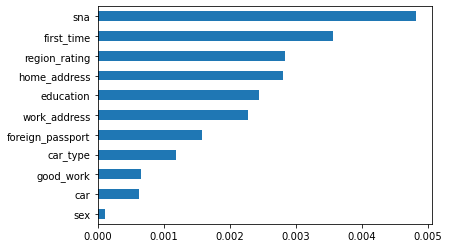

In [34]:
imp_cat = Series(mutual_info_classif(df[bin_cols + cat_cols],
                                     df['default'],
                                     discrete_features=True),
                 index=bin_cols + cat_cols)
imp_cat.sort_values(inplace=True)
imp_cat.plot(kind='barh')

Наиболее значимый параметр - sna.

## Подготовка данных к машинному обучению

### dummy-кодирование

In [35]:
df = pd.get_dummies(df, columns=cat_cols, dummy_na=False)

OneHotEncoder

In [36]:
# X_cat = OneHotEncoder(sparse = False).fit_transform(df[cat_cols].values)

### Стандартизация числовых переменных

In [37]:
df[num_cols] = pd.DataFrame(StandardScaler().fit_transform(df[num_cols]),
                            columns=num_cols)

И объединим стандартизованные числовые, бинарные и закодированные категориальные переменные в одно признаковое пространство, разделив при этом признаки и целевую переменную.

Удаляем поле даты 'app_date'

In [38]:
df.drop('app_date', axis=1, inplace=True)

In [39]:
df.columns
df

Index(['client_id', 'sex', 'age', 'car', 'car_type', 'decline_app_cnt',
       'good_work', 'score_bki', 'bki_request_cnt', 'income',
       'foreign_passport', 'sample', 'default', 'days', 'education_0',
       'education_1', 'education_2', 'education_3', 'education_4',
       'home_address_1', 'home_address_2', 'home_address_3', 'work_address_1',
       'work_address_2', 'work_address_3', 'sna_1', 'sna_2', 'sna_3', 'sna_4',
       'first_time_1', 'first_time_2', 'first_time_3', 'first_time_4',
       'region_rating_20', 'region_rating_30', 'region_rating_40',
       'region_rating_50', 'region_rating_60', 'region_rating_70',
       'region_rating_80'],
      dtype='object')

,client_id,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,income,...,first_time_2,first_time_3,first_time_4,region_rating_20,region_rating_30,region_rating_40,region_rating_50,region_rating_60,region_rating_70,region_rating_80
0,74835,1,-0.888776,1,1,-0.418815,0,-0.735587,0.770563,0.680425,...,0,0,1,0,0,0,1,0,0,0
1,17527,0,0.120447,0,0,4.539989,0,0.800039,0.333797,-2.624624,...,0,1,0,0,0,0,1,0,0,0
2,75683,1,0.972731,1,1,-0.418815,0,0.426908,-0.281790,-0.052834,...,0,1,0,0,0,0,1,0,0,0
3,26883,1,1.362924,0,0,-0.418815,0,-0.940432,-0.281790,-0.868125,...,0,1,0,0,0,1,0,0,0,0
4,28862,0,0.031629,0,0,-0.418815,0,-1.167347,-1.334144,1.937123,...,0,1,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110143,54887,0,0.610749,0,0,-0.418815,0,0.225214,0.770563,-0.868125,...,0,0,1,0,0,0,1,0,0,0
110144,76821,1,0.291609,1,1,-0.418815,0,-0.307360,-0.281790,1.163415,...,0,0,1,0,0,0,1,0,0,0
110145,103695,1,-0.662367,0,0,-0.418815,0,0.784750,1.109345,0.529186,...,1,0,0,0,0,0,0,0,0,1
110146,861,0,-0.888776,0,0,-0.418815,1,0.851432,0.770563,-1.253186,...,0,1,0,0,0,0,1,0,0,0


### Построение модели

In [40]:
def split_data(df):
    # разбделение данных
    X = df[df['sample'] == 1].drop(['client_id', 'sample', 'default'], axis=1)
    y = df[df['sample'] == 1]['default']
    return train_test_split(X, y, test_size=0.20, random_state=random_state)


def simple_model(df):
    # разбделение данных
    X_train, X_test, y_train, y_test = split_data(df)
    # модель
    model = LogisticRegression()
    model.fit(X_train, y_train)
    # вывод результата
    probs = model.predict_proba(X_test)
    probs = probs[:, 1]

    fpr, tpr, threshold = roc_curve(y_test, probs)
    roc_auc = roc_auc_score(y_test, probs)

    plt.figure()
    plt.plot([0, 1], label='Baseline', linestyle='--')
    plt.plot(fpr, tpr, label='Regression')
    plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(loc='lower right')
    plt.show()

#### Модель с параметрами по умолчанию.

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


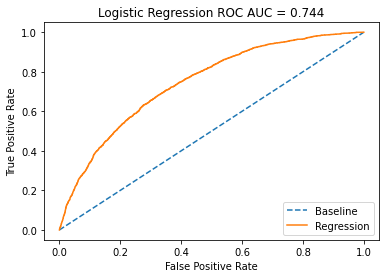

In [41]:
simple_model(df)

#### Тест с выборкой сбалансированной c помощью undersampling

In [42]:
df_t = df[df['sample'] == 1]
df_t['default'].value_counts()

0    64427
1     9372
Name: default, dtype: int64

In [43]:
df_tt = df_t[df_t['default'] == 0].sample(
    n=df_t['default'].value_counts()[1]).append(df_t[df_t['default'] == 1])

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


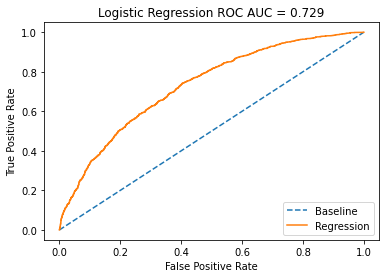

In [44]:
simple_model(df_tt)

#### Тест c удалением выбросов

In [45]:
df_t = df[df['sample'] == 1][~qfil['income'] & ~qfil['score_bki']]

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


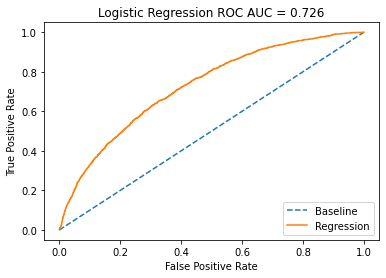

In [46]:
simple_model(df_t)

#### Тест c удалением малозначимых параметров

In [47]:
df_t = df.drop(['car', 'age'], axis=1)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


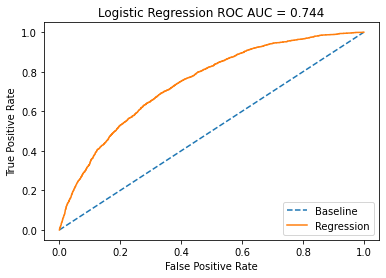

In [48]:
simple_model(df_t)

Результат не улучшился

## Оптимизация гиперпараметров

In [49]:
X_train, X_test, y_train, y_test = split_data(df)

In [50]:
from sklearn.model_selection import GridSearchCV

# Добавим типы регуляризации
penalty = ['l1', 'l2']

# Зададим ограничения для параметра регуляризации
C = np.logspace(0, 4, 10)

# Создадим гиперпараметры
hyperparameters = dict(C=C, penalty=penalty)

model = LogisticRegression()
model.fit(X_train, y_train)

# Создаем сетку поиска с использованием 5-кратной перекрестной проверки
clf = GridSearchCV(model, hyperparameters, cv=5, verbose=0)

best_model = clf.fit(X_train, y_train)

# View best hyperparameters
print('Лучшее Penalty:', best_model.best_estimator_.get_params()['penalty'])
print('Лучшее C:', best_model.best_estimator_.get_params()['C'])

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression()

/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    "got %s penalty." % (solver, penalty))
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTA

/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    "got %s penalty." % (solver, penalty))
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this trai

Лучшее Penalty: l2
Лучшее C: 2.7825594022071245


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


### Результат выбранной модели

<Figure size 432x288 with 0 Axes>

Text(0.5, 1.0, 'Logistic Regression ROC AUC = 0.744')

Text(0, 0.5, 'True Positive Rate')

Text(0.5, 0, 'False Positive Rate')

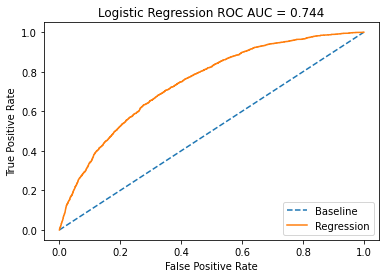

In [51]:
probs = best_model.predict_proba(X_test)
probs = probs[:, 1]

fpr, tpr, threshold = roc_curve(y_test, probs)
roc_auc = roc_auc_score(y_test, probs)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label='Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc='lower right')
plt.show()

## Submission

In [52]:
test_data = df[df['sample'] == 0].drop(['client_id', 'sample', 'default'],
                                       axis=1)

In [53]:
test_data.sample(10)

,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,income,foreign_passport,...,first_time_2,first_time_3,first_time_4,region_rating_20,region_rating_30,region_rating_40,region_rating_50,region_rating_60,region_rating_70,region_rating_80
15852,1,0.686195,1,0,-0.418815,0,0.445419,0.333797,0.360115,0,...,0,0,1,0,0,0,0,0,0,1
34605,0,0.903261,0,0,-0.418815,0,0.635357,-0.281790,-0.434230,0,...,1,0,0,0,0,1,0,0,0,0
25798,1,-1.528382,0,0,-0.418815,0,1.346196,0.770563,0.168439,0,...,0,1,0,0,0,1,0,0,0,0
17112,0,-1.007707,0,0,-0.418815,1,-0.399835,-0.281790,0.360115,0,...,0,0,1,0,0,0,0,0,0,1
5526,1,-0.449689,0,0,1.499512,0,0.159655,1.620186,0.942139,0,...,0,0,0,0,0,0,0,0,1,0
27061,1,-1.976836,0,0,1.499512,0,0.853281,0.333797,0.680425,1,...,0,1,0,0,0,0,1,0,0,0
21501,1,0.207072,1,1,1.499512,0,-0.299217,-1.334144,1.649334,1,...,0,1,0,0,0,0,0,1,0,0
23328,1,1.173250,1,1,-0.418815,0,1.894219,-1.334144,0.680425,0,...,0,0,0,0,0,0,0,0,1,0
33325,0,1.600854,0,0,1.499512,0,1.062284,1.386150,0.680425,0,...,0,1,0,0,0,0,1,0,0,0
16016,1,0.374157,0,0,-0.418815,0,0.373125,-1.334144,-1.950052,0,...,0,0,0,0,0,1,0,0,0,0


In [54]:
test_data.shape, df_test.shape

((36349, 37), (36349, 20))

In [55]:
sample_submission

,client_id,default
0,66799,0.441004
1,25379,0.138092
2,28825,0.373370
3,37530,0.476501
4,4264,0.304640
...,...,...
24349,96657,0.144776
24350,65908,0.878936
24351,74542,0.830871
24352,82350,0.371539


In [56]:
predict_submission = best_model.predict_proba(test_data)

In [57]:
best_model.classes_

array([0, 1])

In [58]:
submit = pd.DataFrame(df[df['sample'] == 0]['client_id'])

In [59]:
submit['default'] = predict_submission[:, 1]

In [60]:
submit

,client_id,default
0,74835,0.039425
1,17527,0.338948
2,75683,0.061148
3,26883,0.088015
4,28862,0.023236
...,...,...
36344,83775,0.326084
36345,106254,0.022794
36346,81852,0.334713
36347,1971,0.202148


In [61]:
submit.sample(10)

,client_id,default
21749,13034,0.282963
3621,38758,0.164000
34799,42394,0.053951
3862,78220,0.062560
18196,95545,0.124779
11028,60742,0.072636
324,102539,0.161340
29469,23673,0.074545
30675,28581,0.044697
12985,81103,0.056889


In [62]:
submit.to_csv('submission.csv', index=False)